# ***Global Air Pollution Analysis (2016–2022)***
*This notebook performs exploratory data analysis on global air quality data to identify pollutant distributions, geographic hotspots, seasonal patterns, temporal trends, and monitoring-source bias.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

In [2]:
df = pd.read_csv("global air quality.csv")
df.head(5)

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,"Kędzierzyn-Koźle, ul. Śmiałego",Kędzierzyn-Koźle,PL,bc,1.21101,2022-05-14 19:00:00.000000 UTC,µg/m³,GIOS,1.0,50.349608,18.236575,POINT(50.349608 1)
1,"Rybnik, ul. Borki",Rybnik,PL,bc,0.87571,2022-05-17 06:00:00.000000 UTC,µg/m³,GIOS,1.0,50.111181,18.516139,POINT(50.111181 1)
2,"Żagań, ul. Kochanowskiego",Żagań,PL,bc,0.11610,2022-05-06 19:00:00.000000 UTC,µg/m³,GIOS,1.0,51.615447,15.301667,POINT(51.615447 1)
3,"Płock, ul. Królowej Jadwigi",Płock,PL,bc,0.16000,2022-05-09 07:00:00.000000 UTC,µg/m³,GIOS,1.0,52.556279,19.687672,POINT(52.556279 1)
4,"Rzeszów, ul. Rejtana",Rzeszów,PL,bc,0.21042,2022-04-28 13:00:00.000000 UTC,µg/m³,GIOS,1.0,50.024242,22.010575,POINT(50.024242 1)


In [3]:
# Shape
print("Shape:", df.shape)

# Data types
print(df.info())

# Summary stats
print(df.describe())

Shape: (9575, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9575 entries, 0 to 9574
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location                9575 non-null   object 
 1   city                    9444 non-null   object 
 2   country                 9575 non-null   object 
 3   pollutant               9575 non-null   object 
 4   value                   9575 non-null   float64
 5   timestamp               9575 non-null   object 
 6   unit                    9575 non-null   object 
 7   source_name             9575 non-null   object 
 8   latitude                9575 non-null   float64
 9   longitude               9575 non-null   float64
 10  averaged_over_in_hours  9575 non-null   float64
 11  location_geom           9575 non-null   object 
dtypes: float64(4), object(8)
memory usage: 897.8+ KB
None
             value     latitude    longitude  averaged_over_in_hours
count

## Dataset Fields
- city — monitoring city
- country — country code
- pollutant — pollutant type
- value — pollution measurement
- timestamp — measurement time
- latitude/longitude — station coordinates
- source_name — monitoring network
- averaged_over_in_hours — averaging window
 
*DATA SOURCE - Source: OpenAQ Global Air Quality Dataset (bigquery-public-data.openaq.global_air_quality)*

In [4]:
# CONVERTS TIMESTAMP TO DATETIME 
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

In [5]:
# NUMBER OF MISSING VALUES
df.isna().sum()

location                    0
city                      131
country                     0
pollutant                   0
value                       0
timestamp                   0
unit                        0
source_name                 0
latitude                    0
longitude                   0
averaged_over_in_hours      0
location_geom               0
year                        0
month                       0
day                         0
hour                        0
dtype: int64

In [6]:
# PERCENT OF MISSING VALUES IN THE DATA
df.isna().mean()*100

location                  0.000000
city                      1.368146
country                   0.000000
pollutant                 0.000000
value                     0.000000
timestamp                 0.000000
unit                      0.000000
source_name               0.000000
latitude                  0.000000
longitude                 0.000000
averaged_over_in_hours    0.000000
location_geom             0.000000
year                      0.000000
month                     0.000000
day                       0.000000
hour                      0.000000
dtype: float64

In [7]:
neg_counts = df[df['value'] < 0]['pollutant'].value_counts()
print(neg_counts)

# REMOVING NEGATIVE VALUES
df = df[df['value'] >= 0].copy()

pollutant
pm25    52
no2     45
pm10    29
so2     20
o3      15
co       6
Name: count, dtype: int64


*Negative concentration values were observed across multiple pollutants (PM2.5, NO₂, PM10, SO₂, O₃, and CO), indicating sensor or calibration artifacts. Since pollutant concentrations cannot be negative, these records were removed to prevent distortion of averages and trends.*

In [8]:
# FILL MISSING VALUES WITH UNKOWN
df['city'] = df['city'].fillna("Unknown")

# CORRECT ISO CODE
df['country'] = df['country'].replace({
    'BK': 'BA',   # Bosnia & Herzegovina
    'SU': 'SD',   # Sudan
    'TX': 'TM',   # Turkmenistan
    'IZ': 'IQ',   # Iraq (US diplomatic code)
    'TI': 'TJ'    # Tajikistan
})

- *The city column contained approximately 1.37% missing values. Missing city values were not randomly distributed across countries. The majority (over 80%) occurred in CA records, suggesting possible systematic data collection differences. To avoid introducing bias, missing city values were replaced with “Unknown”.*

- *Country codes were standardized to ISO-3166 format during data cleaning to ensure consistent grouping and accurate comparisons. Some monitoring networks used non-standard codes (such as “IZ” for Iraq in U.S. diplomatic data), which would otherwise split the same country into separate groups and distort averages and rankings. Converting all codes to ISO format prevents duplication and improves aggregation accuracy and cross-dataset comparability.*

In [9]:
country_map = {
    'PL': 'Poland',
    'US': 'United States',
    'TR': 'Turkey',
    'ME': 'Montenegro',
    'AR': 'Argentina',
    'IL': 'Israel',
    'CN': 'China',
    'AT': 'Austria',
    'AU': 'Australia',
    'BG': 'Bulgaria',
    'BR': 'Brazil',
    'CA': 'Canada',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'ES': 'Spain',
    'FR': 'France',
    'HK': 'Hong Kong',
    'IN': 'India',
    'IT': 'Italy',
    'MX': 'Mexico',
    'NO': 'Norway',
    'PT': 'Portugal',
    'RS': 'Serbia',
    'SK': 'Slovakia',
    'TH': 'Thailand',
    'ZA': 'South Africa',
    'MT': 'Malta',
    'GR': 'Greece',
    'GT': 'Guatemala',
    'LV': 'Latvia',
    'HU': 'Hungary',
    'HR': 'Croatia',
    'DK': 'Denmark',
    'CH': 'Switzerland',
    'PE': 'Peru',
    'CY': 'Cyprus',
    'IE': 'Ireland',
    'FI': 'Finland',
    'GB': 'United Kingdom',
    'MK': 'North Macedonia',
    'NL': 'Netherlands',
    'RO': 'Romania',
    'SE': 'Sweden',
    'BE': 'Belgium',
    'CL': 'Chile',
    'SI': 'Slovenia',
    'LU': 'Luxembourg',
    'BA': 'Bosnia and Herzegovina',
    'KW': 'Kuwait',
    'MM': 'Myanmar',
    'TJ': 'Tajikistan',
    'IQ': 'Iraq',
    'SD': 'Sudan',
    'AD': 'Andorra',
    'LT': 'Lithuania',
    'PK': 'Pakistan',
    'MA': 'Morocco',
    'DZ': 'Algeria',
    'NP': 'Nepal',
    'ET': 'Ethiopia',
    'AE': 'United Arab Emirates',
    'KG': 'Kyrgyzstan',
    'ID': 'Indonesia',
    'CI': 'Ivory Coast',
    'MN': 'Mongolia',
    'BH': 'Bahrain',
    'QA': 'Qatar',
    'TD': 'Chad',
    'TM': 'Turkmenistan'
}

In [10]:
df['country'] = df['country'].map(country_map).fillna(df['country'])

*Country identifiers in the dataset were stored as ISO-3166 alpha-2 codes. During data preparation, non-standard and dataset-specific country codes were first corrected to their proper ISO equivalents to ensure consistent grouping. The standardized ISO codes were then mapped to full country names to improve readability and interpretability in tables, charts, and visualizations. This step does not change the analytical grouping logic but enhances presentation clarity while preserving aggregation accuracy.*

In [11]:
df.duplicated().sum()

np.int64(0)

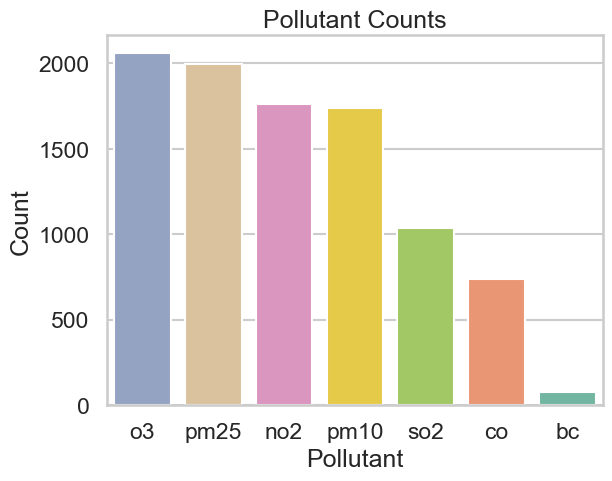

In [37]:
sns.set_theme(style="whitegrid", context="talk")
palette='Set2'

sns.countplot(
    data=df,
    x='pollutant',
    order=df['pollutant'].value_counts().index,
    palette=palette,
    hue='pollutant'
)

plt.title("Pollutant Counts")
plt.xlabel("Pollutant")
plt.ylabel("Count")

plt.savefig(r"C:\Users\user\Desktop\Data Science\Pollutant Counts.jpg",
            dpi=300, bbox_inches="tight")

plt.show()

The chart shows that O₃ and PM2.5 are the most frequently recorded pollutants, followed by NO₂ and PM10, indicating they are the main focus of global air-quality monitoring. These pollutants are widely tracked because they are major health indicators, strongly regulated, and easier to measure consistently.

SO₂ and CO have fewer records, while Black Carbon (BC) is very limited, likely due to higher measurement cost and more specialized monitoring needs.

Implication: Analyses involving O₃, PM2.5, NO₂, and PM10 are more reliable, while findings for SO₂, CO, and especially BC should be treated cautiously because they are based on fewer observations.

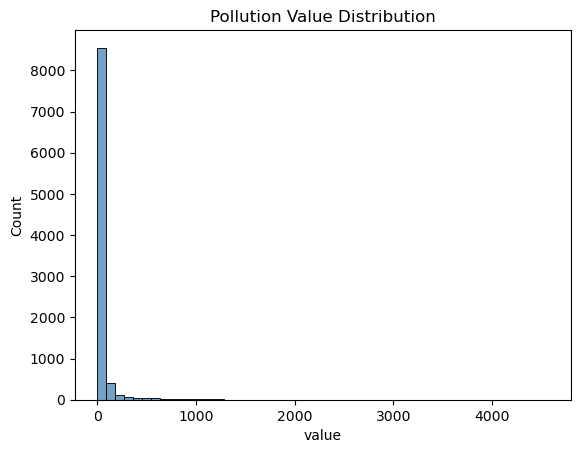

In [13]:
sns.histplot(df['value'], bins=50, kde=False, color="steelblue", edgecolor="black")
plt.title("Pollution Value Distribution")
plt.savefig(r"C:\Users\user\Desktop\Data Science\Pollution Value Distribution.jpg", dpi=300, bbox_inches="tight")

*Most pollution levels are low, but a few extreme spikes create a right-skewed pattern that can distort averages and should be treated carefully in analysis.*

*These spikes represent extreme pollution events or hotspot locations.*

*The median gives a more typical picture of normal pollution levels.*

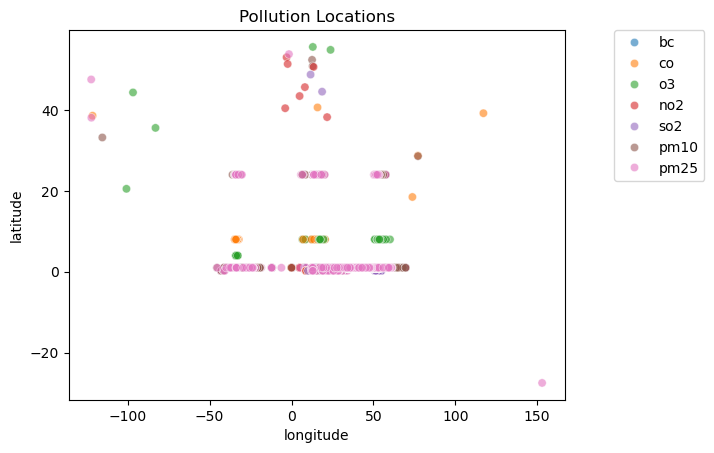

<Figure size 1400x800 with 0 Axes>

In [14]:
sns.scatterplot(data=df,
                x='longitude',
                y='latitude',
                hue='pollutant',
                alpha=0.6)
plt.title("Pollution Locations")
# Move the legend outside the plot to the right
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
plt.figure(figsize=(14, 8))
plt.tight_layout()
plt.savefig(r"C:\Users\user\Desktop\Data Science\Pollution Locations.jpg", dpi=300, bbox_inches="tight")

*Pollution monitoring points in the dataset are not evenly distributed globally but are highly clustered in specific regions, especially South Asia (India–Pakistan cities like Delhi and Mumbai), the Turkey–Middle East corridor, parts of Europe, and eastern China. A few stations appear in the United States, but far fewer than in the main clusters, showing that coverage depends more on monitoring network presence than equal geographic sampling.*

*Most stations lie between 20°N and 55°N, making the dataset Northern Hemisphere–dominant, with limited Southern Hemisphere coverage (Africa south, South America, Oceania underrepresented). Longitude patterns align with urban and industrial corridors, indicating infrastructure-driven placement.*

*Overall, the dataset is strongest for analyzing urban and industrial pollution hotspots, but less representative of rural or global background air quality. Results mainly reflect where sensors are installed, so conclusions should be interpreted with sensor coverage bias in mind.*

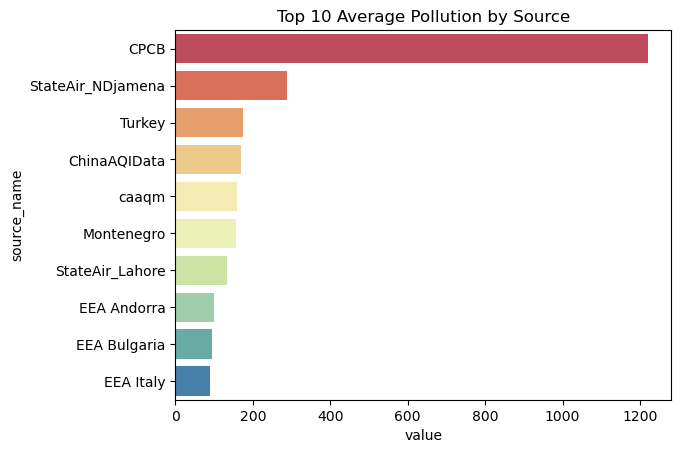

In [15]:
sns.barplot(
    data=df.groupby('source_name')['value']
           .mean().sort_values(ascending=False)
           .head(10).reset_index(),
    x='value', y='source_name',
    hue='source_name', palette="Spectral", legend=False
)
plt.title("Top 10 Average Pollution by Source")
plt.savefig(r"C:\Users\user\Desktop\Data Science\Avg Pollution by Source.jpg",
            dpi=300, bbox_inches="tight")
plt.show()

*Average pollution levels vary widely by monitoring source, showing that results are strongly influenced by who collects the data and where sensors are placed. The dataset is not source-neutral — monitoring network design significantly affects reported averages.*

*CPCB (India) records the highest averages, largely because many of its stations are located in major cities, traffic corridors, and industrial hotspots, and are affected by winter smog, crop burning, and dense urban emissions. StateAir monitoring in N’Djamena also shows high values, likely driven by regional dust exposure and natural particulate loads.*

*Mid-range sources such as Turkey, ChinaAQIData, caaqm, and Montenegro represent broad urban monitoring networks with mixed environments. European Environment Agency sources report the lowest averages, likely due to stronger regulations and more evenly distributed stations, including background locations.*

***Key implication: Differences reflect both real pollution conditions and sensor placement strategy, so cross-source comparisons should account for monitoring network bias.***

In [16]:
df.groupby('country').size()

country
Algeria                    1
Andorra                    4
Argentina                 10
Australia                255
Austria                  230
                        ... 
Turkey                    16
Turkmenistan               1
United Arab Emirates       2
United Kingdom           439
United States           2363
Length: 69, dtype: int64

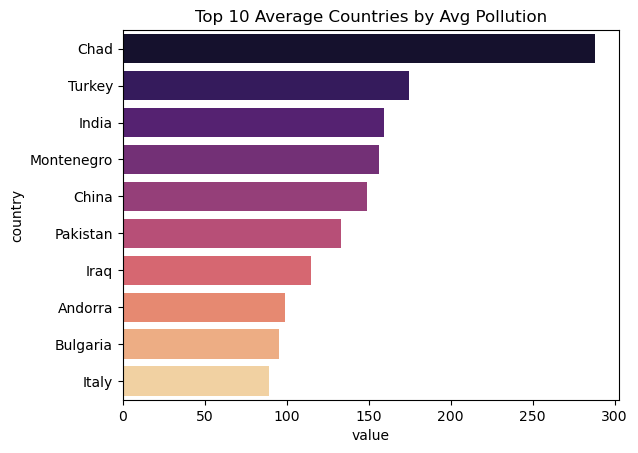

In [17]:
sns.barplot(
    data=df.groupby('country')['value']
           .mean().sort_values(ascending=False)
           .head(10).reset_index(),
    x='value', y='country',
    hue='country', palette="magma", legend=False
)
plt.title("Top 10 Average Countries by Avg Pollution")
plt.savefig(r"C:\Users\user\Desktop\Data Science\Top 10 Countries by Avg Pollution.jpg",
            dpi=300, bbox_inches="tight")
plt.show()

*Chad shows the highest average pollution in the dataset, followed by Turkey, India, Montenegro, China, Pakistan, and Iraq, while Andorra, Bulgaria, and Italy sit at the lower end of the top-10 list. Higher averages are mainly associated with urban density, industrial and traffic emissions, fossil-fuel use, and natural dust exposure.*

*Major contributors include Sahara/Middle East dust events, India’s crop burning and winter smog, rapid urban and traffic growth, and oil and energy-related emissions in Iraq, along with industrial activity in Turkey and China. Lower-ranking countries likely reflect localized hotspots and stronger environmental controls.*

*Overall, the rankings reflect both true pollution conditions and monitoring station concentration, not fully uniform national air quality.*

In [18]:
df['city'] = df['city'].apply(lambda x: unidecode(str(x)))

top10 = (
    df.groupby(['city','country'])['value']
      .mean()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)


top10['label'] = top10['city'] + ", " + top10['country']

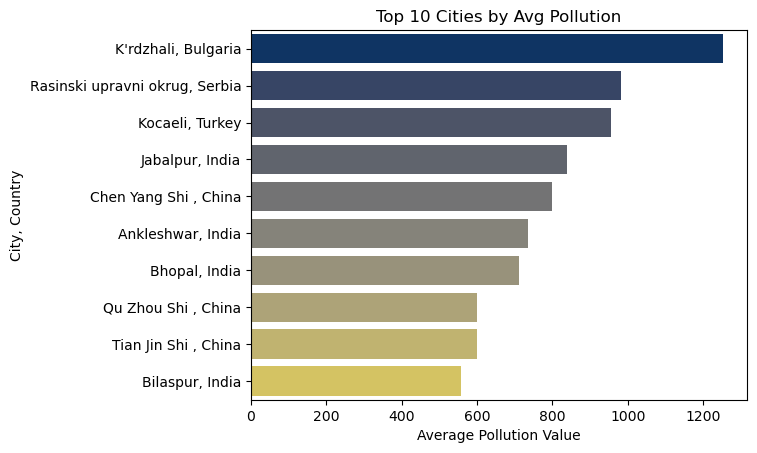

In [19]:
sns.barplot(
    data=top10,
    x='value',
    y='label',
    hue='label',
    palette="cividis"
    
)

plt.title("Top 10 Cities by Avg Pollution")
plt.xlabel("Average Pollution Value")
plt.ylabel("City, Country")

plt.savefig(r"C:\Users\user\Desktop\Data Science\Top 10 Cities by Avg Pollution.jpg",
            dpi=300, bbox_inches="tight")

plt.show()

*The city-level chart supports the country-level results by showing that the highest pollution averages come from specific urban and industrial hotspots, not entire countries uniformly. The top cities are mainly in India, China, Turkey, Serbia, and Bulgaria, matching the countries that ranked highest overall.*

*These cities are associated with industrial activity, heavy traffic, energy production, and rapid urban growth, which explains their elevated values. Having multiple Indian and Chinese cities in the top 10 confirms that urbanization, industrial emissions, and seasonal pollution events drive higher national averages.*

*Overall, the chart shows that country rankings are strongly shaped by hotspot cities and monitoring station locations, not evenly distributed national pollution levels.*

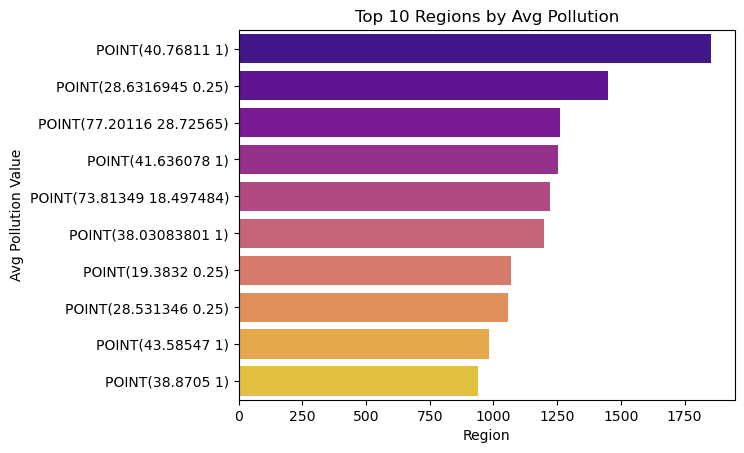

In [20]:
sns.barplot(
    data=df.groupby('location_geom')['value']
           .mean().sort_values(ascending=False)
           .head(10).reset_index(),
    x='value', y='location_geom',
    hue='location_geom', palette="plasma", legend=False
)
plt.ylabel("Avg Pollution Value")
plt.xlabel("Region")
plt.title("Top 10 Regions by Avg Pollution")
plt.savefig(r"C:\Users\user\Desktop\Data Science\Top 10 Regions by Avg Pollution.jpg",
            dpi=300, bbox_inches="tight")
plt.show()

In [21]:
df_ts = df.set_index('timestamp').sort_index()

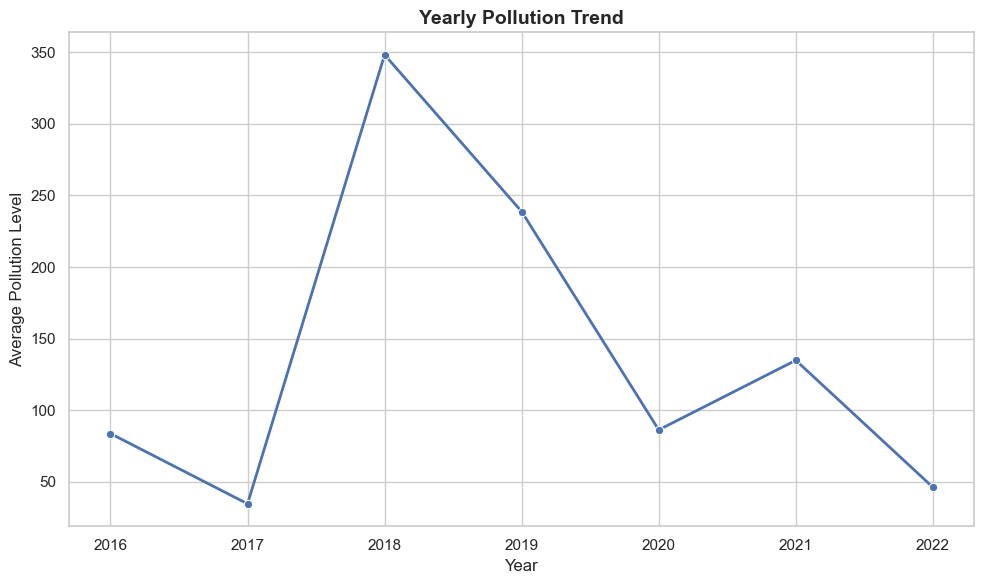

In [22]:
yearly_avg = df.groupby('year', as_index=False)['value'].mean()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,6))

sns.lineplot(
    data=yearly_avg,
    x='year',
    y='value',
    marker='o',
    linewidth=2,
    color=sns.color_palette("deep")[0]
)

plt.title("Yearly Pollution Trend", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Average Pollution Level")

plt.tight_layout()
plt.savefig(r"C:\Users\user\Desktop\Data Science\Yearly Pollution Trend.jpg", dpi=300)
plt.show()

*Pollution levels fluctuate noticeably over time, with moderate values in 2016, a dip in 2017, and a sharp peak in 2018, remaining high in 2019 — likely due to strong seasonal events and heavy urban-industrial emissions. Levels drop significantly in 2020 in line with COVID-19 lockdown effects (reduced traffic and industry), followed by a partial rebound in 2021 as activities resumed. The lower 2022 value should be treated cautiously because it likely reflects partial-year data and uneven coverage. Overall, yearly averages reflect both real emission changes and differences in monitoring coverage and hotspot sampling.*

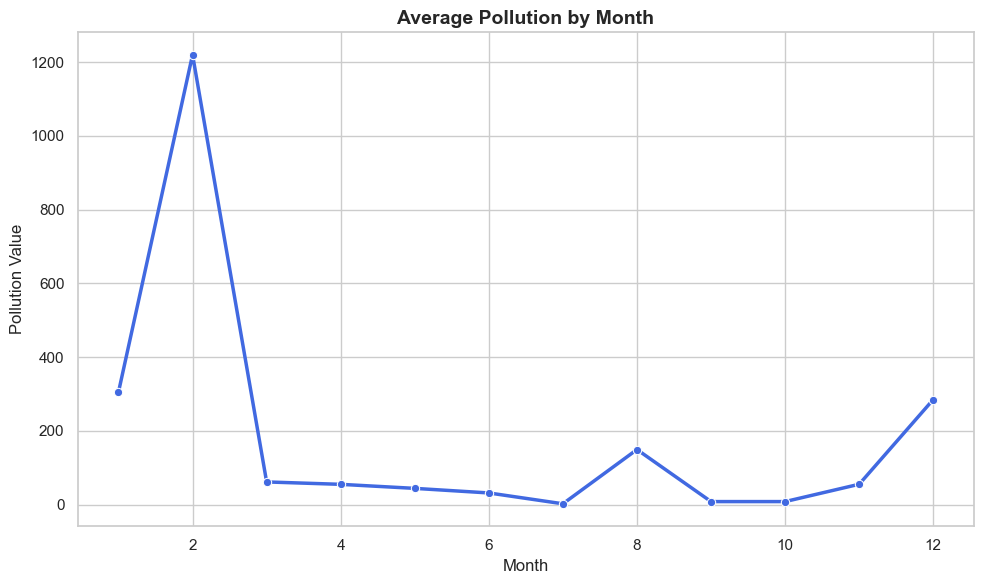

In [23]:
monthly_avg = df.groupby('month', as_index=False)['value'].mean()
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,6))

sns.lineplot(
    data=monthly_avg,
    x='month',
    y='value',
    marker='o',
    linewidth=2.5,
    color='royalblue'
)

plt.title("Average Pollution by Month", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Pollution Value")

plt.tight_layout()
plt.savefig(r"C:\Users\user\Desktop\Data Science\Average Pollution by Month.jpg", dpi=300)
plt.show()

*Pollution is strongly seasonal — highest in winter, lowest in early summer — driven by heating emissions, atmospheric trapping, and seasonal burning, with occasional spikes from regional extreme events.*

*Pollution shows a strong seasonal pattern, with the highest averages in winter — especially January and February — driven by heating emissions, temperature inversions, and seasonal biomass/crop burning. Levels drop through spring and are lowest in early summer (June–July) due to warmer weather and better atmospheric mixing. A secondary rise appears in late summer and year-end (August and December), likely linked to dust events, wildfires, festivals, and renewed heating activity. Monthly spikes may be partly influenced by localized extreme events and hotspot sensor placement, but the overall seasonal trend is clear.*

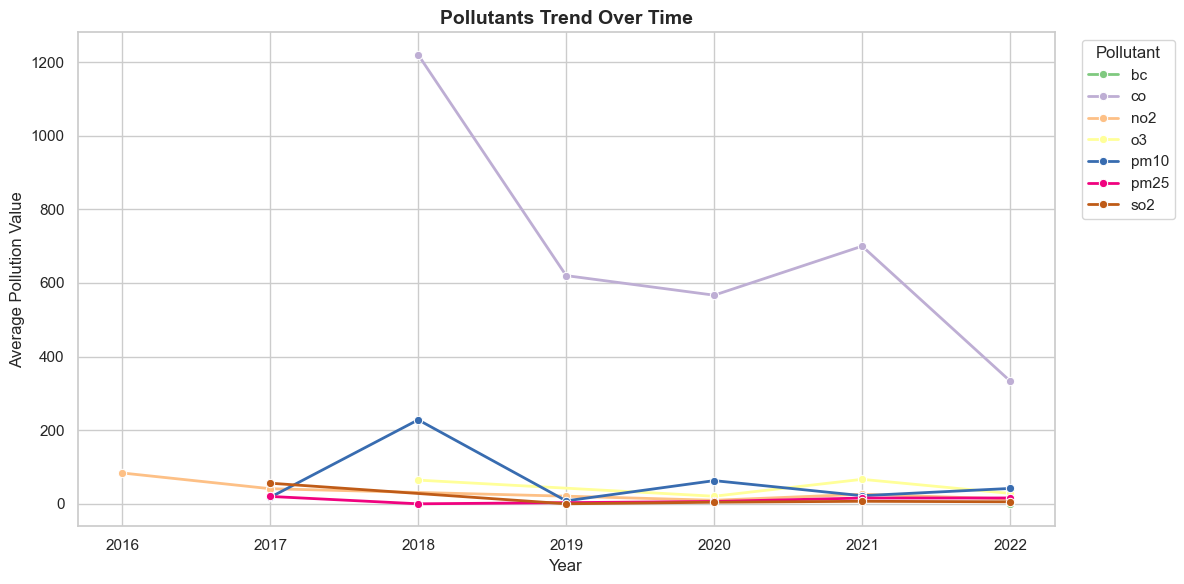

In [39]:
trend = (df.groupby(['pollutant', 'year'], as_index=False)['value']
           .mean()
           .rename(columns={'value': 'avg_value'}))

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

sns.lineplot(
    data=trend,
    x="year",
    y="avg_value",
    hue="pollutant",
    marker="o",
    linewidth=2,
    palette = "Accent"

)

plt.title("Pollutants Trend Over Time", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Average Pollution Value")

plt.legend(title="Pollutant", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(r"C:\Users\user\Desktop\Data Science\Pollutants Trend Over Time.jpg", dpi=300)
plt.show()

*Air quality is driven by multiple sources — mainly traffic, fuel combustion, industry, and seasonal burning — not a single factor. The largest changes are seen in CO and particulate matter (PM10, PM2.5), confirming that vehicles, generators, construction, and burning activities are major contributors.*

*Extreme events (dust storms, wildfires, heavy burning seasons) create sharp spikes, while COVID-era slowdowns showed that reduced traffic and industry quickly improve air quality. Regulations have helped lower NO₂ and SO₂, but particulates remain harder to control. Ozone behaves differently because it forms through atmospheric reactions, and black carbon appears flat mostly due to limited monitoring.*

*Overall, the data shows a major peak around 2018, a dip in 2020, and partial rebound in 2021, with pollution improving when combustion and traffic drop — but seasonal and urban factors can still cause large spikes*

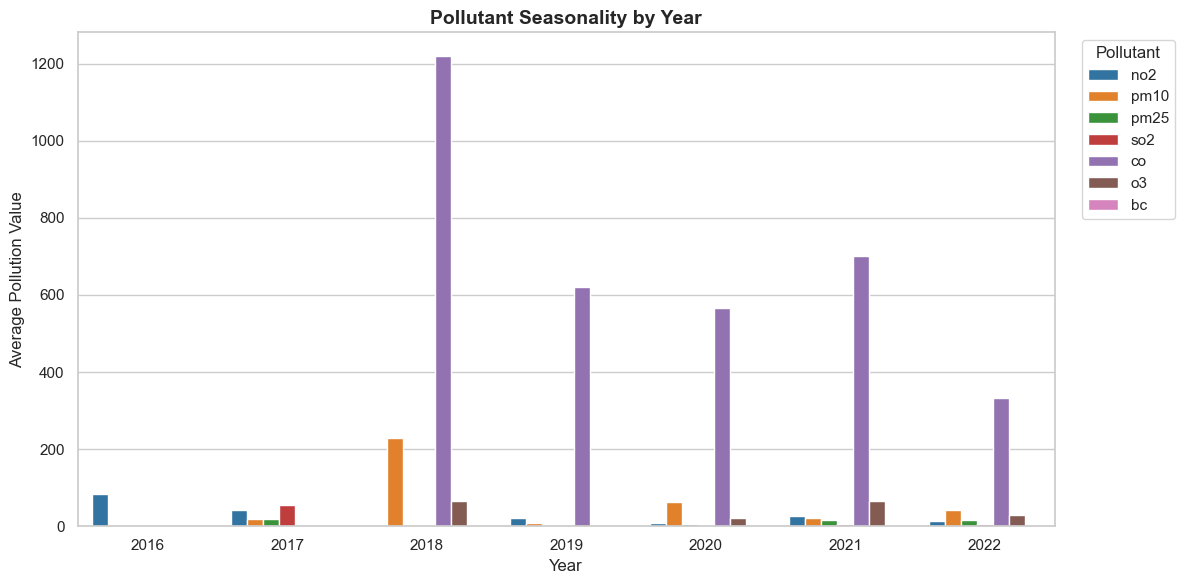

In [25]:
trend = (
    df.groupby(['pollutant','year'], as_index=False)['value']
      .mean()
      .rename(columns={'value':'avg_value'})
)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))

sns.barplot(
    data=trend,
    x="year",
    y="avg_value",
    hue="pollutant",
    palette="tab10"
)

plt.title("Pollutant Seasonality by Year", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Average Pollution Value")

plt.legend(title="Pollutant", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()

plt.savefig(r"C:\Users\user\Desktop\Data Science\Pollutants seasonality.jpg", dpi=300)
plt.show()


*Pollution peaks in 2018–2019 align with real-world events such as major wildfire seasons, South Asian crop burning, and Middle East/North Africa dust episodes, which strongly raised CO and particulate (PM10/PM2.5) levels. CO shows the largest swings, reflecting growing vehicle fleets and generator use in rapidly urbanizing regions. PM spikes are event-driven and drop afterward, matching seasonal burning and dust cycles. A clear multi-pollutant dip in 2020 corresponds to COVID-19 lockdowns that reduced traffic, flights, and industry, followed by a partial rebound in 2021 as economies reopened and moderation in 2022. Meanwhile, NO₂ and SO₂ trend downward overall, consistent with stricter vehicle standards, cleaner fuels, and emission regulations. Overall, the trends confirm that real-world activity, extreme events, and policy controls directly shape air quality patterns.*

2018 stands out as a multi-pollutant spike year — especially for CO and PM10.
👉 Real-world support: 2018–2019 recorded major global wildfire seasons (including large events in North America and parts of Asia), strong South Asian crop-residue burning episodes, and notable dust events across the Middle East and North Africa — all known to sharply raise CO and particulate levels.

CO shows the largest swings and dominates peak periods.
👉 Real-world support: Across 2016–2019, many rapidly growing cities (especially in South Asia and parts of the Middle East) experienced rising vehicle fleets and heavy generator use due to energy instability — both major CO sources from incomplete fuel combustion.

PM10 & PM2.5 spikes align with event years, then fall afterward.
👉 Real-world support: Documented seasonal crop burning in North India (annual Oct–Nov cycles), recurring Middle East dust storms, and urban construction booms in developing cities contributed to episodic particulate surges visible in those peak years.

Clear dip around 2020 across several pollutants.
👉 Real-world support: Global COVID-19 lockdowns (2020) caused well-documented air quality improvements worldwide — satellite and ground data showed large NO₂ and PM reductions due to traffic collapse, flight reductions, and industrial slowdowns.

Partial rebound in 2021, moderation in 2022.
👉 Real-world support: Economic reopening in 2021 restored traffic and industrial activity, raising pollution again, while continued hybrid work patterns and some sustained controls kept levels from fully returning to earlier peaks in many regions.

NO₂ and SO₂ trend generally lower over time.
👉 Real-world support: Tightening vehicle emission standards (Euro 6, Bharat Stage VI in India from 2020), low-sulfur fuel policies, and cleaner power regulations in multiple regions directly targeted NO₂ and SO₂ emissions during this period.

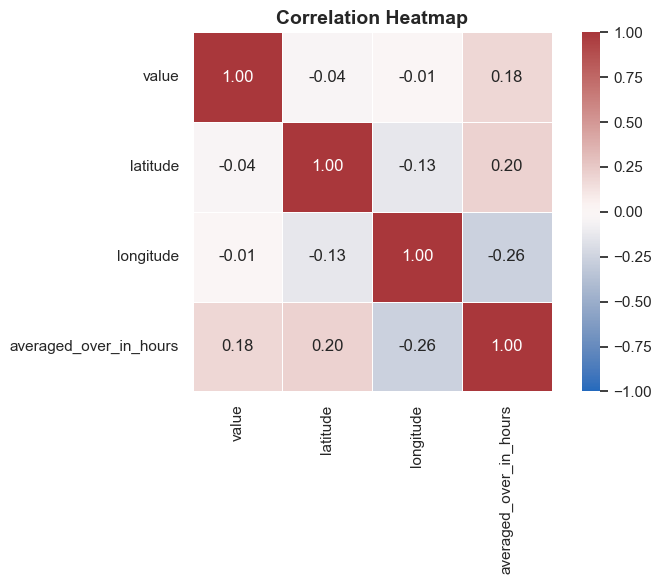

In [26]:
numeric_cols = ['value','latitude','longitude','averaged_over_in_hours']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))

cmap="vlag"

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True
)

plt.title("Correlation Heatmap", fontsize=14, weight="bold")

plt.tight_layout()
plt.savefig(r"C:\Users\user\Desktop\Data Science\Correlation Heatmap.jpg",
            dpi=300, bbox_inches="tight")
plt.show()

*Correlation results show that pollution values have near-zero linear relationship with latitude and longitude, meaning pollution is not explained by simple geographic position but by local urban, industrial, and hotspot factors. There is a small positive link between pollution values and averaging duration, suggesting measurement and aggregation methods slightly affect reported levels. Geographic coordinates and averaging time also show weak relationships, indicating monitoring network clustering and methodological differences across regions.*

***No strong linear correlations exist — pollution variability in the dataset is mainly location-specific and network-driven, not coordinate-driven.***

### ***FINAL TAKEAWAY**

- *Air pollution in the dataset is mainly driven by traffic, fuel combustion, industry, and seasonal burning.*

- *Air quality in the dataset shows strong geographic, seasonal, and event-driven patterns, with combustion and particulate pollutants (especially CO and PM10) driving the largest variability and extreme spikes. Pollution levels cluster around urban and industrial hotspots, and trends clearly reflect real-world events such as wildfire seasons and COVID-19 lockdown reductions. While regulation appears to reduce some pollutants (NO₂, SO₂), particulate pollution remains highly variable. Results should be interpreted with awareness of monitoring network bias, missing coverage, and outlier effects.*

- *Pollution is concentrated in urban and industrial hotspots, not evenly distributed. Highest country averages (e.g., Chad, Turkey, India, China, Pakistan, Iraq) are driven by specific high-pollution cities and station placement, meaning results reflect sensor network design plus real conditions.*

- *Pollution is seasonal — highest in winter (Jan–Feb) due to heating and inversions, lowest in spring–early summer, with smaller late-year spikes from dust, fires, and burning events.*

### *Limitations:*
*Results are affected by uneven geographic coverage, hotspot bias, differing measurement methods, outliers, under-monitored pollutants (BC), and partial recent-year data.*